# Training machines to smell - Part 2: Exploratory data analysis (EDA) and feature engineering (FE).

## Overview

In this notebook code for exploratory data analysis and feature engineering will be provided. For the sake of organization, it was better to split the project into 3 notebook files.

##  EDA and FE Task 1: Predict odor intensity

Now we have the features, we can see that there are a lot of them (4867). In the same way that too few features can fail to explaing the target variable variability, too many features can have a similar effect for parametric models such as **Kernel Ridge Regressor**. Before training this model, we need to: explore features distribution. Then in FE drop features with low variability and investigate their correlation.

For the **random forest**, I will use the raw features and let the algorithm figure out how to do predictions.

### EDA

In [1]:
# Importing libraries 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.pylab as pylab

In [2]:
# For styling graphics
legend_size = 14
params = {'xtick.top': True,
          'ytick.right': True,
          'xtick.major.size': 5,
          'ytick.major.size': 5,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
    'legend.fontsize': legend_size,
          'figure.figsize': (11, 6),
          'figure.dpi': 100,
         'axes.labelsize': 20,
         'axes.titlesize':22,
         'xtick.labelsize':16,
         'ytick.labelsize':16,
         'lines.linewidth': 3,
        'lines.markersize': 16}
pylab.rcParams.update(params)

Now we have the features, we can see that there are a lot of them (4867). In the same way that too few features can fail to explaing the target variable variability, too many features can have a similar effect. Before training any model, we need to: investigate missing values, explore features features distribution. Then in FE drop features with low variability and investigate their correlation.

In the cell below, I simply load the ``X_train.csv`` and ``y_train.csv`` arrays createad in notebook PART 1 and drop an ininteded column that was created during save.

In [3]:
#Loading the data set for task 1 with missing rows removed
X = pd.read_csv('task1/X_train.csv')
y = pd.read_csv('task1/y_train.csv')
y_2 = pd.read_csv('task2/y_train.csv')

**Data Distribution**

Before moving to transforming the features, it is useful to explore their distribution and basic statistics. When getting set of features and targets, few attributes of the data mass worth being observed for the purpose of building a predictive model:data types,variability, symetry, correlation - covariance. This is so, because it can actually affect the performance. Too many features can cause trouble in parametric models such as linear regression, kernel ridge, so we have to find a way to reduce it. 

For each of such attributes, there are strategies to overcome them. If features have low variability for instance, it may be better to drop it - nobody can expect filling a column with constant value and be able to predict a target with it. Assymetric distributions (also named skewed) may also cause trouble for features and for targets. For the target, you may end up having a bad performance in the region with low data density (thinking about error minimization) - a way to circumvent it is applying some transformation to the features in regression. 
Correlated features may also cause trouble by the known colinearity problem. To correct it, a dimensionality reduction method can be used such as PCA.

In the following cells, I will look carefully for each of the possible problems the data may have

**Target distribution**

In [4]:
y.iloc[:,1:].describe()

,INTENSITY/STRENGTH
count,25762.000000
mean,53.977874
std,33.070849
min,0.000000
25%,23.000000
50%,61.000000
75%,82.000000
max,100.000000


The target distribution is not symmetric and not skewed. It looks like the distribution is multimodal and there a lot of zeros and 100. Predicting 0's will be problematic since most of the models parameters cannot be trained with such constraint (y_predicted > 0). I will simply truncate predictions smaller than zero to zero! 

Moreover, we can see that the perception of individuals about the same smell have an enormous variability. This may happen due to the fact that the subjects are untrained panelists (people who distinguish smells) and did not had the opportunity to develop a good strategy to consistently classify the stimuli. 

The figure below displays the variability for molecule 1 across subjects

In [5]:
mol_id = X.CID.unique()
rows  = X.loc[X.CID == mol_id[0]].index.to_list()

Variability of molecule CID 126 across subjects


(0.0, 100.0)

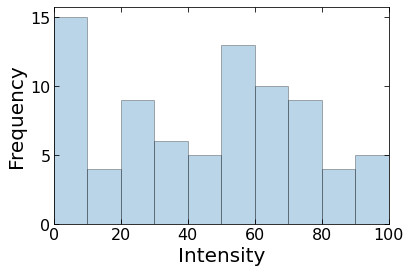

In [6]:
%matplotlib inline
print('Variability of molecule CID', mol_id[0], 'across subjects')
x = y.iloc[rows,1:].values
fig, ax = plt.subplots()
kwargs = dict(histtype='bar', alpha=0.3, ec="k")
ax.hist(x, **kwargs)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
ax.set_xlim([0,100])
#ax.set_rasterized(True)
#fig.savefig('y_cid126.pdf',format = 'pdf', dpi = 200, bbox_inches='tight')

###  Feature Engineering (For parametric model Kernel Ridge Regressor)

**Checking data types**

By previous inspection, I saw that there are features which are binary int64 and others that are float64. int64 usually refer to numerical discrete variables and float64 to continuous (real values).

From previous inspection, I verified that the following variables were categorical and featurized using one hot encoding. They have to treated differently than continuous features

In [7]:
binary  = ['Inflammat-80', 'Inflammat-50', 'Depressant-80','Depressant-50','Psychotic-80','Psychotic-50',
 'Hypertens-80', 'Hypertens-50','Hypnotic-80', 'Hypnotic-50',
 'Neoplastic-80' , 'Neoplastic-50', 'Infective-80', 'Infective-50', 'CMC-50', 'CMC-80']

In [8]:
X_int = X[binary]
X_real = X.drop(binary, axis = 1).iloc[:,1:]

In [9]:
print(X_int.shape)

(25762, 16)


In [10]:
print(X_real.shape)

(25762, 4853)


**Building a variability filter**

* We have to check for variability in columns. I remove continuous features based on variance and int features based on how much 1s there are compared to the total number of rows.

Continuous columns

In [11]:
#Calculating variance for continuous variables
variances = X_real.apply(np.var)

#Setting a threshold
variance_threshold = 2

In [12]:
#Getting column names with variance higher than threshold
good_cols = variances[variances > variance_threshold].index.to_list()

In [13]:
#Retrieving good cols from X dataframe
X_real = X_real[good_cols]

In [14]:
X_real.shape

(25762, 917)

Binary columns

In [15]:
sparseness = X_int.apply(lambda x: x.sum()/len(x))

In [16]:
good_int = sparseness[sparseness > .075].index.to_list()

In [17]:
X_int = X_int[good_int]

In [18]:
X_int.shape

(25762, 4)

We can see that setting a variance threshold allowed to get a reduction factor of 4 in the number of features. 

Check some features and target distribution as well as how the target vary across subjects.

**Correlation analysis**

* Even after dropping few columns that had no appreciable variability, we can see that still there are a lot of features and they are probably correlated with each other (it can hurt training performance due to colinearity problem). In this way, a good method to reduce the number features dimension is by implementing a dimensionality reduction method - PCA is widely available including in scikitlearn!


**Feature correlation.**

Real variables

In [19]:
#Joining features and target dataframes
X_y = pd.concat([X_real, y.iloc[:,1:]], axis = 1)

Storing target names in a list ``target_names`` and real feature names in ``real_feature_names``.

In [20]:
target_names = y.iloc[:,1:].columns.to_list()
real_feature_names = X_real.columns.to_list()

In [21]:
print(len(real_feature_names))

917


Calculating correlation matrix with ``pd.DataFrame.corr()`` method.

In [22]:
correlations = X_y.corr()

In [23]:
X_y = None

In [24]:
correlations.loc[real_feature_names, real_feature_names].head(3)

,complexity from pubmed,MW,AMW,Sv,Se,Sp,Si,nAT,nSK,nBT,...,TPSA(NO),TPSA(Tot),MLOGP2,ALOGP2,SAtot,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ
complexity from pubmed,1.000000,0.741338,-0.082108,0.771273,0.672499,0.719411,0.641314,0.654253,0.859988,0.691624,...,0.308990,0.101394,0.441286,0.428648,0.662253,0.206363,-0.091190,0.726825,0.726825,0.748716
MW,0.741338,1.000000,0.312306,0.860859,0.784663,0.858467,0.761193,0.772365,0.876775,0.787259,...,0.196325,0.097500,0.659561,0.658248,0.837070,0.126943,-0.073957,0.882193,0.882193,0.870118
AMW,-0.082108,0.312306,1.000000,-0.179117,-0.252381,-0.141391,-0.262496,-0.255410,-0.140743,-0.251420,...,-0.031753,0.047341,-0.054856,-0.142554,-0.149927,-0.037921,-0.026175,-0.116791,-0.116792,-0.145941


Integer variables

In [25]:
Xint_y = pd.concat([X_int, y.iloc[:,1:]], axis = 1)

In [26]:
int_corr = Xint_y.corr()

In [27]:
int_corr

,Hypnotic-80,Neoplastic-80,Infective-80,CMC-80,INTENSITY/STRENGTH
Hypnotic-80,1.000000,0.536797,0.693763,0.817992,-0.062909
Neoplastic-80,0.536797,1.000000,0.559012,0.672132,-0.047641
Infective-80,0.693763,0.559012,1.000000,0.774653,-0.055796
CMC-80,0.817992,0.672132,0.774653,1.000000,-0.086768
INTENSITY/STRENGTH,-0.062909,-0.047641,-0.055796,-0.086768,1.000000


The table shows that continuous features are highly correlated with each other (up to 99%) and maybe running a PCA can reduce the number of features significantly.

Here I will use sklearn fuctionality to run the PCA.

Before applying PCA, it is important to rescale the data set. Here I will scale by centering and dividing by the standard deviation.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Scaling the data

In [29]:
X_scaler = StandardScaler()

In [30]:
X_scaled  = X_scaler.fit_transform(X_real)

Performing PCA

In [31]:
components = PCA(n_components = X_real.shape[1]).fit(X_scaled)

To select our features, we must check how much components are necessary to explain most of feature variance. 

In [35]:
n_components = 60
components.explained_variance_ratio_[0:n_components].sum()

0.9854472802116625

We can see that with 60 components, we can retain 0.95 of variance. So we will simply retain 26 of them and transform the original data set.

In [36]:
Z = PCA(n_components = n_components).fit_transform(X_scaled)

**Saving n_components principal components**

After transforming the data, it is better to rescale them so, again with standard scaler.

In [37]:
Z_scaler = StandardScaler()

In [38]:
Z_scaled = Z_scaler.fit_transform(Z)

Transforming ``Z_scaled`` in a dataframe

In [39]:
z_names = ['z{}'.format(i) for i in range(1, n_components + 1)]

In [40]:
Z_scaled = pd.DataFrame(Z_scaled, columns = z_names)

Joining ``Z_scaled`` with ``X_int``.

In [41]:
X_Z = pd.concat([X_int, Z_scaled], axis = 1)

In [42]:
X_Z.shape

(25762, 64)

Saving features and targets together as the training set.

In [43]:
if not os.path.isdir('task1/krr_train'):
    os.mkdir('task1/krr_train')

In [44]:
pd.concat([y.iloc[:,1:], X_Z], axis = 1).to_csv('task1/krr_train/train.csv', index = False, header = False)

Saving U array as a dataframe.

In [45]:
vectors = pd.DataFrame(components.components_).iloc[0:n_components, :]

Vaving transformed covariance matrix to ``u_array.csv`` file.

In [48]:
vectors.to_csv('task1/u_array.csv', index = False, header = False)

AttributeError: 'NoneType' object has no attribute 'to_csv'

Cleaning memory.

In [47]:
components = Z = Z_scaled = vectors =  X = X_int = y = X_Z = X_scaled = X_real =  None

###  Feature transformation - leaderboard and test sets

Here I will only transform the generated features using PCA. All exploration is done in the training set.

Pipelining

In [49]:
def pipeline(df, int_cols, real_cols, pca_u):
    ''' Function to preprocess features of leaderboard and test sets
    
    '''
    
    X_real = df[real_cols]
    X_scaled = X_scaler.transform(X_real)
    
    Z = np.matmul(X_scaled, pca_u.transpose().values)
    Z_scaled = Z_scaler.transform(Z)
    
    X_int = df[int_cols].values
    X_Z = np.concatenate((X_int, Z_scaled), axis = 1)
    
    return X_Z
    

Loading leaderboard features and pca components

In [2]:
X_ldb = pd.read_csv('task1/X_ldb.csv')
X_test = pd.read_csv('task1/X_test.csv')
pca_u = pd.read_csv('task1/u_array.csv', header = None)
y_test = pd.read_csv('task1/y_test.csv')
y_ldb = pd.read_csv('task1/y_ldb.csv')

In [3]:
y_test

,INTENSITY/STRENGTH,subject #
0,0,1
1,85,2
2,56,3
3,74,4
4,0,5
...,...,...
3327,14,45
3328,0,46
3329,40,47
3330,94,48


Creating features

In [51]:
X_Z_ldb = pipeline(X_ldb, good_int, real_feature_names, pca_u)

In [52]:
X_Z_test = pipeline(X_test, good_int, real_feature_names, pca_u)

Concatenating labels with features for validation and test and saving as csv

In [53]:
pd.concat([y_ldb, pd.DataFrame(X_Z_ldb)], axis = 1).to_csv('task1/krr_train/validation.csv', header = None, index = None)

In [54]:
pd.concat([y_test, pd.DataFrame(X_Z_test)], axis = 1).to_csv('task1/krr_train/test.csv', header = None, index = None)